In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.8 MB/s 


In [ ]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 990 kB 5.1 MB/s 


In [ ]:
import os
import re
import argparse
import numpy as np
import random
import monai
import time
# from networks import build_net
import logging
import os
import sys
import tempfile
from glob import glob
#from ignite.metrics import Accuracy
import nibabel as nib
import torch
import argparse
from monai.data import CacheDataset, DataLoader, Dataset
import SimpleITK as sitk
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.data import NiftiSaver, create_test_image_3d, list_data_collate
from collections import OrderedDict
#from monai.handlers import (MeanDice, StatsHandler, ValidationHandler, CheckpointSaver, LrScheduleHandler, CheckpointLoader,
 #                        SegmentationSaver, TensorBoardImageHandler, TensorBoardStatsHandler)
from monai.inferers import SimpleInferer, SlidingWindowInferer
from monai.utils import set_determinism
import re
from monai.data import create_test_image_3d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.transforms import (Activationsd,MeanEnsembled, GaussianSmoothd, CropForegroundd, ThresholdIntensityd, Activations,AsDiscrete, LoadImaged, AsChannelFirstd, VoteEnsembled, AsDiscreted, Compose, AddChanneld, Transpose, ConcatItemsd,
                              ScaleIntensityd, Resized,ToTensord, RandSpatialCropd, Rand3DElasticd, RandAffined, RandGaussianSmoothd, SpatialPadd,
    Spacingd, Orientationd, RandShiftIntensityd, BorderPadd, RandGaussianNoised, RandAdjustContrastd,NormalizeIntensityd,RandFlipd, KeepLargestConnectedComponent)

#from monai.engines import (
 #   EnsembleEvaluator,
  #  SupervisedEvaluator,
  #  SupervisedTrainer
#)

from skimage.measure import label
def getLargestCC(segmentation):
    labels = label(segmentation)
    unique, counts = np.unique(labels, return_counts=True)
    list_seg=list(zip(unique, counts))[1:] # the 0 label is by default background so take the rest
    largest=max(list_seg, key=lambda x:x[1])[0]
    labels_max=(labels == largest).astype(int)
    return labels_max


def Padding(image, reference):


    size_new = reference.GetSize()

    output_size = tuple(size_new)

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(reference.GetSpacing())
    resampler.SetSize(output_size)

    # resample on label
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetOutputOrigin(reference.GetOrigin())
    resampler.SetOutputDirection(reference.GetDirection())

    image = resampler.Execute(image)

    return image


def resize(img, new_size, interpolator):
    # img = sitk.ReadImage(img)
    dimension = img.GetDimension()

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    reference_physical_size[:] = [(sz - 1) * spc if sz * spc > mx else mx for sz, spc, mx in
                                  zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]

    # Create the reference image with a zero origin, identity direction cosine matrix and dimension
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()
    reference_size = new_size
    reference_spacing = [phys_sz / (sz - 1) for sz, phys_sz in zip(reference_size, reference_physical_size)]

    reference_image = sitk.Image(reference_size, img.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    # Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as
    # this takes into account size, spacing and direction cosines. For the vast majority of images the direction
    # cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the
    # spacing will not yield the correct coordinates resulting in a long debugging session.
    reference_center = np.array(
        reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize()) / 2.0))

    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize()) / 2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))

    # centered_transform = sitk.Transform(transform)
    # centered_transform.AddTransform(centering_transform)

    centered_transform = sitk.CompositeTransform([transform, centering_transform])

    # Using the linear interpolator as these are intensity images, if there is a need to resample a ground truth
    # segmentation then the segmentation image should be resampled using the NearestNeighbor interpolator so that
    # no new labels are introduced.

    return sitk.Resample(img, reference_image, centered_transform, interpolator, 0.0)


def resample_sitk_image(sitk_image, spacing=None, interpolator=None, fill_value=0):
    # https://github.com/SimpleITK/SlicerSimpleFilters/blob/master/SimpleFilters/SimpleFilters.py
    _SITK_INTERPOLATOR_DICT = {
        'nearest': sitk.sitkNearestNeighbor,
        'linear': sitk.sitkLinear,
        'gaussian': sitk.sitkGaussian,
        'label_gaussian': sitk.sitkLabelGaussian,
        'bspline': sitk.sitkBSpline,
        'hamming_sinc': sitk.sitkHammingWindowedSinc,
        'cosine_windowed_sinc': sitk.sitkCosineWindowedSinc,
        'welch_windowed_sinc': sitk.sitkWelchWindowedSinc,
        'lanczos_windowed_sinc': sitk.sitkLanczosWindowedSinc
    }

    if isinstance(sitk_image, str):
        sitk_image = sitk.ReadImage(sitk_image)
    num_dim = sitk_image.GetDimension()

    if not interpolator:
        interpolator = 'linear'
        pixelid = sitk_image.GetPixelIDValue()

        if pixelid not in [1, 2, 4]:
            raise NotImplementedError(
                'Set `interpolator` manually, '
                'can only infer for 8-bit unsigned or 16, 32-bit signed integers')
        if pixelid == 1:  # 8-bit unsigned int
            interpolator = 'nearest'

    orig_pixelid = sitk_image.GetPixelIDValue()
    orig_origin = sitk_image.GetOrigin()
    orig_direction = sitk_image.GetDirection()
    orig_spacing = np.array(sitk_image.GetSpacing())
    orig_size = np.array(sitk_image.GetSize(), dtype=np.int)

    if not spacing:
        min_spacing = orig_spacing.min()
        new_spacing = [min_spacing] * num_dim
    else:
        new_spacing = [float(s) for s in spacing]

    assert interpolator in _SITK_INTERPOLATOR_DICT.keys(), \
        '`interpolator` should be one of {}'.format(_SITK_INTERPOLATOR_DICT.keys())

    sitk_interpolator = _SITK_INTERPOLATOR_DICT[interpolator]

    new_size = orig_size * (orig_spacing / new_spacing)
    new_size = np.ceil(new_size).astype(np.int)  # Image dimensions are in integers
    new_size = [int(s) for s in new_size]  # SimpleITK expects lists, not ndarrays

    resample_filter = sitk.ResampleImageFilter()

    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    resample_filter.SetOutputDirection(orig_direction)
    resample_filter.SetOutputOrigin(orig_origin)
    resample_filter.SetTransform(sitk.Transform())
    resample_filter.SetDefaultPixelValue(orig_pixelid)
    resample_filter.SetInterpolator(sitk_interpolator)
    resample_filter.SetDefaultPixelValue(fill_value)

    resampled_sitk_image = resample_filter.Execute(sitk_image)

    return resampled_sitk_image


def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


def lstFiles(Path):

    images_list = []  # create an empty list, the raw image data files is stored here
    for dirName, subdirList, fileList in os.walk(Path):
        for filename in fileList:
            if ".nii.gz" in filename.lower():
                images_list.append(os.path.join(dirName, filename))
            elif ".nii" in filename.lower():
                images_list.append(os.path.join(dirName, filename))
            elif ".mhd" in filename.lower():
                images_list.append(os.path.join(dirName, filename))

    images_list = sorted(images_list, key=numericalSort)

    return images_list


def new_state_dict(file_name):
    state_dict = torch.load(file_name)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k[:6] == 'module':
            name = k[7:]
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


def new_state_dict_cpu(file_name):
    state_dict = torch.load(file_name, map_location='cpu')
    new_state_dict_cpu = OrderedDict()
    for k, v in state_dict.items():
        if k[:6] == 'module':
            name = k[7:]
            new_state_dict_cpu[name] = v
        else:
            new_state_dict_cpu[k] = v
    return new_state_dict_cpu


def from_numpy_to_itk(image_np, image_itk):

    # read image file
    reader = sitk.ImageFileReader()
    reader.SetFileName(image_itk)
    image_itk = reader.Execute()

    image_np = np.transpose(image_np, (2, 1, 0))
    image = sitk.GetImageFromArray(image_np)
    image.SetDirection(image_itk.GetDirection())
    image.SetSpacing(image_itk.GetSpacing())
    image.SetOrigin(image_itk.GetOrigin())
    return image


# function to keep track of the cropped area and coordinates
def statistics_crop(image, resolution):

    files = [{"image": image}]

    reader = sitk.ImageFileReader()
    reader.SetFileName(image)
    image_itk = reader.Execute()
    original_resolution = image_itk.GetSpacing()

    # original size
    transforms = Compose([
        LoadImaged(keys=['image']),
        AddChanneld(keys=['image']),
        ToTensord(keys=['image'])])
    data = monai.data.Dataset(data=files, transform=transforms)
    loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
    loader = monai.utils.misc.first(loader)
    im, = (loader['image'][0])
    vol = im.numpy()
    original_shape = vol.shape

    # cropped foreground size
    transforms = Compose([
        LoadImaged(keys=['image']),
        AddChanneld(keys=['image']),
        CropForegroundd(keys=['image'], source_key='image', start_coord_key='foreground_start_coord',
                        end_coord_key='foreground_end_coord', ),  # crop CropForeground
        ToTensord(keys=['image', 'foreground_start_coord', 'foreground_end_coord'])])

    data = monai.data.Dataset(data=files, transform=transforms)
    loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
    loader = monai.utils.misc.first(loader)
    im, coord1, coord2 = (loader['image'][0], loader['foreground_start_coord'][0], loader['foreground_end_coord'][0])
    vol = im[0].numpy()
    coord1 = coord1.numpy()
    coord2 = coord2.numpy()
    crop_shape = vol.shape

    if resolution is not None:

        transforms = Compose([
            LoadImaged(keys=['image']),
            AddChanneld(keys=['image']),
            CropForegroundd(keys=['image'], source_key='image'),  # crop CropForeground
            Spacingd(keys=['image'], pixdim=resolution, mode=('bilinear')),  # resolution
            ToTensord(keys=['image'])])

        data = monai.data.Dataset(data=files, transform=transforms)
        loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
        loader = monai.utils.misc.first(loader)
        im, = (loader['image'][0])
        vol = im.numpy()
        resampled_size = vol.shape

    else:

        resampled_size = original_shape

    return original_shape, crop_shape, coord1, coord2, resampled_size, original_resolution


def crop_window(prostate_contour):
    # Cut data, restricted to the prostate contours + a pitch per direction per dimension.
    """
    nrrd has the following format, assuming to watch the patient from the front:
    (x, y, z)
    x: left to right (ascending)
    y: front to back (ascending)
    z: bottom to top (ascending)
    """
    pitch = 5
    pattern = np.where(prostate_contour == 1)

    minx = np.min(pattern[0]) - pitch
    maxx = np.max(pattern[0]) + pitch
    miny = np.min(pattern[1]) - pitch
    maxy = np.max(pattern[1]) + pitch
    minz = np.min(pattern[2]) - pitch
    maxz = np.max(pattern[2]) + pitch

    if (maxx - minx) % 2 != 0:
        maxx += 1
    if (maxy - miny) % 2 != 0:
        maxy += 1
    if (maxz - minz) % 2 != 0:
        maxz += 1

    """
    Choose all tensors to have size of 64x64x64
    """
    limit = 32

    while maxx - minx < limit:
        maxx += 1
        minx -= 1

    while maxy - miny < limit:
        maxy += 1
        miny -= 1

    while maxz - minz < limit:
        maxz += 1
        minz -= 1

    return minx, maxx, miny, maxy, minz, maxz


def uniform_img_dimensions(image, label, nearest):

    image_array = sitk.GetArrayFromImage(image)
    image_array = np.transpose(image_array, axes=(2, 1, 0))  # reshape array from itk z,y,x  to  x,y,z
    image_shape = image_array.shape

    if nearest is True:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='nearest')
        res = resize(label,image_shape,sitk.sitkNearestNeighbor)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('uint8'))
        # print(res.GetSize())

    else:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='linear')
        res = resize(label, image_shape, sitk.sitkLinear)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('float'))

    res.SetDirection(image.GetDirection())
    res.SetOrigin(image.GetOrigin())
    res.SetSpacing(image.GetSpacing())

    return image, res


def uniform_img_dimensions_internal(image, label, nearest):

    name_label = label

    image = sitk.ReadImage(image)
    label = sitk.ReadImage(label)
    image_array = sitk.GetArrayFromImage(image)
    image_array = np.transpose(image_array, axes=(2, 1, 0))  # reshape array from itk z,y,x  to  x,y,z
    image_shape = image_array.shape

    if nearest is True:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='nearest')
        res = resize(label,image_shape,sitk.sitkNearestNeighbor)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('uint8'))
        # print(res.GetSize())

    else:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='linear')
        res = resize(label, image_shape, sitk.sitkLinear)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('float'))

    res.SetDirection(image.GetDirection())
    res.SetOrigin(image.GetOrigin())
    res.SetSpacing(image.GetSpacing())

    sitk.WriteImage(res, name_label)



def processing_itk(label_CT, image_PET, label_PET, gluteus, new_resolution, patch_size):

    gluteus = sitk.ReadImage(gluteus)
    label_CT = sitk.ReadImage(label_CT)
    image_PET = sitk.ReadImage(image_PET)

    if label_PET is not None:
        label_PET = sitk.ReadImage(label_PET)

    if new_resolution is not None:
        image_PET = resample_sitk_image(image_PET, spacing=new_resolution, interpolator='linear')

    label_CT = Padding(label_CT, image_PET)
    gluteus = Padding(gluteus, image_PET)
    image_PET, label_CT = uniform_img_dimensions(image_PET, label_CT, True)
    image_PET, gluteus = uniform_img_dimensions(image_PET, gluteus, True)

    # new part for Pet tumor_background normalization

    gluteos_ROI_array = sitk.GetArrayFromImage(gluteus)
    gluteos_ROI_index = np.where(gluteos_ROI_array == 1)
    PET_array = sitk.GetArrayFromImage(image_PET)
    avg = np.mean(PET_array[gluteos_ROI_index])
    image_PET = normalize_PET(image_PET, avg)

    # end normalization

    if label_PET is not None:
        label_PET = Padding(label_PET, image_PET)
        image_PET, label_PET = uniform_img_dimensions(image_PET, label_PET, True)

    label_CT_array = sitk.GetArrayFromImage(label_CT)

    minx, maxx, miny, maxy, minz, maxz = crop_window(label_CT_array)

    roiFilter = sitk.RegionOfInterestImageFilter()
    roiFilter.SetSize(patch_size)
    roiFilter.SetIndex([int(minz), int(miny), int(minx)])

    label_CT = roiFilter.Execute(label_CT)
    image_PET = roiFilter.Execute(image_PET)

    if label_PET is not None:
        label_PET = roiFilter.Execute(label_PET)
    else:
        label_PET = None

    sitk.WriteImage(label_CT, 'mask_crop.nii')
    sitk.WriteImage(image_PET, 'result.nii')

    if label_PET is not None:

        sitk.WriteImage(label_PET, 'label_crop.nii')


def gaussian2(image):

    resacleFilter = sitk.RescaleIntensityImageFilter()
    resacleFilter.SetOutputMaximum(255)
    resacleFilter.SetOutputMinimum(0)
    image = resacleFilter.Execute(image)  # set intensity 0-255

    gaussianFilter = sitk.SmoothingRecursiveGaussianImageFilter()
    gaussianFilter.SetSigma(3)
    image = gaussianFilter.Execute(image)

    resacleFilter = sitk.RescaleIntensityImageFilter()
    resacleFilter.SetOutputMaximum(1)
    resacleFilter.SetOutputMinimum(0)
    image = resacleFilter.Execute(image)  # set intensity 0-255

    thresholdFilter = sitk.BinaryThresholdImageFilter()
    thresholdFilter.SetLowerThreshold(0.5)
    thresholdFilter.SetUpperThreshold(2)
    thresholdFilter.SetInsideValue(1)
    thresholdFilter.SetOutsideValue(0)
    image = thresholdFilter.Execute(image)

    return image

In [ ]:
a='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_flair.nii.gz'
b='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/derivatives/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_msk.nii.gz'
c='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_dwi.nii.gz'
e='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_adc.nii.gz'
label = sitk.ReadImage(b) ### label modality
image = sitk.ReadImage(a)  ########### flair modality
image_dwi = sitk.ReadImage(c) ############### dwi imaging
image_adc = sitk.ReadImage(e) ############### adc imaging
#labelorg=label
#orgimage=image

image1 = resample_sitk_image(image, spacing=(2.0,2.0,2.0), interpolator='linear', fill_value=0)
imagef, labelf = uniform_img_dimensions(image1, label, nearest=True)
image2 = resample_sitk_image(image_dwi, spacing=(2.0,2.0,2.0), interpolator='linear', fill_value=0)
imaged, labeld = uniform_img_dimensions(image2, label, nearest=True)
image3 = resample_sitk_image(image_adc, spacing=(2.0,2.0,2.0), interpolator='linear', fill_value=0)
imageadc,labeladc=uniform_img_dimensions(image3, label, nearest=True)
padd_f_dwi = Padding(imagef, imaged) #### padding between falir and dwi images to get labels
#padd_dwi_adc = Padding(imageadc,imaged) #### padding between falir and dwi images to get labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:168: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

In [ ]:
cd /content/drive/MyDrive/ISLES2022

/content/drive/MyDrive/ISLES2022


In [ ]:
!mkdir modality_data
!mkdir modality_mask

In [ ]:
import os
import SimpleITK as sitk
import nibabel as nib
import glob
path='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version'
pathdwi=glob.glob(os.path.join(path,'rawdata','*','*','*_dwi.nii.gz'))
#pathflair=glob.glob(os.path.join(path,'rawdata','*','*','*_flair.nii.gz'))
#pathadc=glob.glob(os.path.join(path,'rawdata','*','*','*_adc.nii.gz'))
#pathmask=glob.glob(os.path.join(path,'derivatives','*','*','*_msk.nii.gz'))
save_imgs='/content/drive/MyDrive/ISLES2022/modality_data'
save_mask='/content/drive/MyDrive/ISLES2022/modality_mask'
for i in range(0,len(pathdwi)):
  #print(i)
  pathdwif=pathdwi[i]
  pathflair=pathdwif.replace('dwi','flair')
  pathadc=pathdwif.replace('dwi','adc')
  pathmsk=pathdwif.replace('rawdata','derivatives').replace('dwi','msk')
  ########### get sitk object
  label = sitk.ReadImage(pathmsk) ### label modality
  image = sitk.ReadImage(pathflair)  ########### flair modality
  image_dwi = sitk.ReadImage(pathdwif) ############### dwi imaging
  image_adc = sitk.ReadImage(pathadc) ############### adc imaging
  ################
  image1 = resample_sitk_image(image, spacing=(2.0,2.0,2.0), interpolator='linear', fill_value=0)
  imagef, labelf = uniform_img_dimensions(image1, label, nearest=True)
  image2 = resample_sitk_image(image_dwi, spacing=(2.0,2.0,2.0), interpolator='linear', fill_value=0)
  imaged, labeld = uniform_img_dimensions(image2, label, nearest=True)
  image3 = resample_sitk_image(image_adc, spacing=(2.0,2.0,2.0), interpolator='linear', fill_value=0)
  imageadc,labeladc=uniform_img_dimensions(image3, label, nearest=True)
  padd_f_dwi = Padding(imagef, imaged) #### padding between falir and dwi images to get labels
#padd_dwi_adc = Padding(imageadc,imaged) #### padding between falir and dwi images to get labels
  ############# get array 
  imge_f=sitk.GetArrayFromImage(imagef)  ########## image flair
  imgedw=sitk.GetArrayFromImage(imaged)  ############ image dwi
  labl=sitk.GetArrayFromImage(labeld)     ############# label
  f_to_dwi=sitk.GetArrayFromImage(padd_f_dwi)  ########### padding f_dwi
  dwitoadc=sitk.GetArrayFromImage(image3)  ########### padding f_dwi
  #print(imge_f.shape)
  print(imgedw.shape)
  print(labl.shape)
  print(f_to_dwi.shape)
  print(dwitoadc.shape)
  img_array_dwi=sitk.GetImageFromArray(imgedw)
  img_array_adc=sitk.GetImageFromArray(dwitoadc)
  img_array_flair=sitk.GetImageFromArray(f_to_dwi)
  img_array_label=sitk.GetImageFromArray(labl)
  sitk.WriteImage(img_array_dwi,os.path.join(save_imgs,pathdwif.split('/')[-1]))
  sitk.WriteImage(img_array_flair,os.path.join(save_imgs,pathdwif.split('/')[-1].replace('dwi','flair')))
  sitk.WriteImage(img_array_adc,os.path.join(save_imgs,pathdwif.split('/')[-1].replace('dwi','adc')))
  sitk.WriteImage(img_array_label,os.path.join(save_mask,pathdwif.split('/')[-1].replace('dwi','msk')))
  #break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:168: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(73, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 

In [ ]:
patterndwi=pathdwif.split('/')[-1]
print(patterndwi)
patternflair=pathdwif.split('/')[-1].replace('dwi','flair')
print(patternflair)
patternadc=pathdwif.split('/')[-1].replace('dwi','adc')
print(patternadc)
patternmask=pathdwif.split('/')[-1].replace('dwi','msk')
print(patternmask)

sub-strokecase0005_ses-0001_dwi.nii.gz
sub-strokecase0005_ses-0001_flair.nii.gz
sub-strokecase0005_ses-0001_adc.nii.gz
sub-strokecase0005_ses-0001_msk.nii.gz


In [ ]:
patternmask=pathdwif.split('/')[-1].replace('dwi','msk')

In [ ]:
patternadc=pathdwif.split('/')[-1].replace('dwi','adc')

In [ ]:
patternflair=pathdwif.split('/')[-1].replace('dwi','flair')

In [ ]:
print(pathdwif)
print(pathflair)
print(pathadc)
print(pathmsk)

/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_dwi.nii.gz
/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_flair.nii.gz
/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_adc.nii.gz
/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/derivatives/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_msk.nii.gz


In [ ]:
pathdwif.replace('rawdata','derivatives').replace('dwi','msk')

'/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/derivatives/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_msk.nii.gz'

In [ ]:
pathdwi[0]

'/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_dwi.nii.gz'

In [ ]:
imge_f=sitk.GetArrayFromImage(imagef)  ########## image flair
imgedw=sitk.GetArrayFromImage(imaged)  ############ image dwi
labl=sitk.GetArrayFromImage(labeld)     ############# label
f_to_dwi=sitk.GetArrayFromImage(padd_f_dwi)  ########### padding f_dwi
dwitoadc=sitk.GetArrayFromImage(image3)  ########### padding f_dwi
print(imge_f.shape)
print(imgedw.shape)
print(labl.shape)
print(f_to_dwi.shape)
print(dwitoadc.shape)

(115, 121, 121)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)
(72, 112, 112)


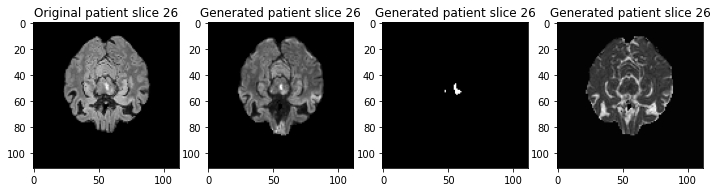

In [ ]:
import matplotlib.pyplot as plt
number_slice = 26
plt.figure("display", (12, 6))
plt.subplot(1, 4, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(f_to_dwi[number_slice,:,:], cmap="gray")
plt.subplot(1, 4, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(imgedw[number_slice,:,:], cmap="gray")
plt.subplot(1, 4, 3)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(labl[number_slice,:,:], cmap="gray")
plt.subplot(1, 4, 4)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(dwitoadc[number_slice,:,:], cmap="gray")